<a href="https://colab.research.google.com/github/JordanHT-OIT/electrodynamics/blob/master/midterm_project/PHY330_Midterm_Project_JHT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Colab notbook is intended to provide a basic investigation into the potential distribution and local electric field if a needle of finite 'sharpness'. <br>
This is motivated by the relative lack of information on the local fields of extremely pointed objects - a niche but important geometry found in, among other things, electron guns. These devices use a potential differential between two electrodes, the cathode of which uses a pointed geometry to concentrate the electrons in the tip. Some of the electrons at the tip have enough thermal energy to physically leave the cathode in a process konwn as thermionic emission. <br>
One type of electron gun uses a special catode, coequally called a field emmiter (or more precisely, a Schottky-emitter), uses a ultra-fine tungsten needle to achieve thermionic emission at comparatively low temperatures. This catode may or may not be heated depending on the application.<br>

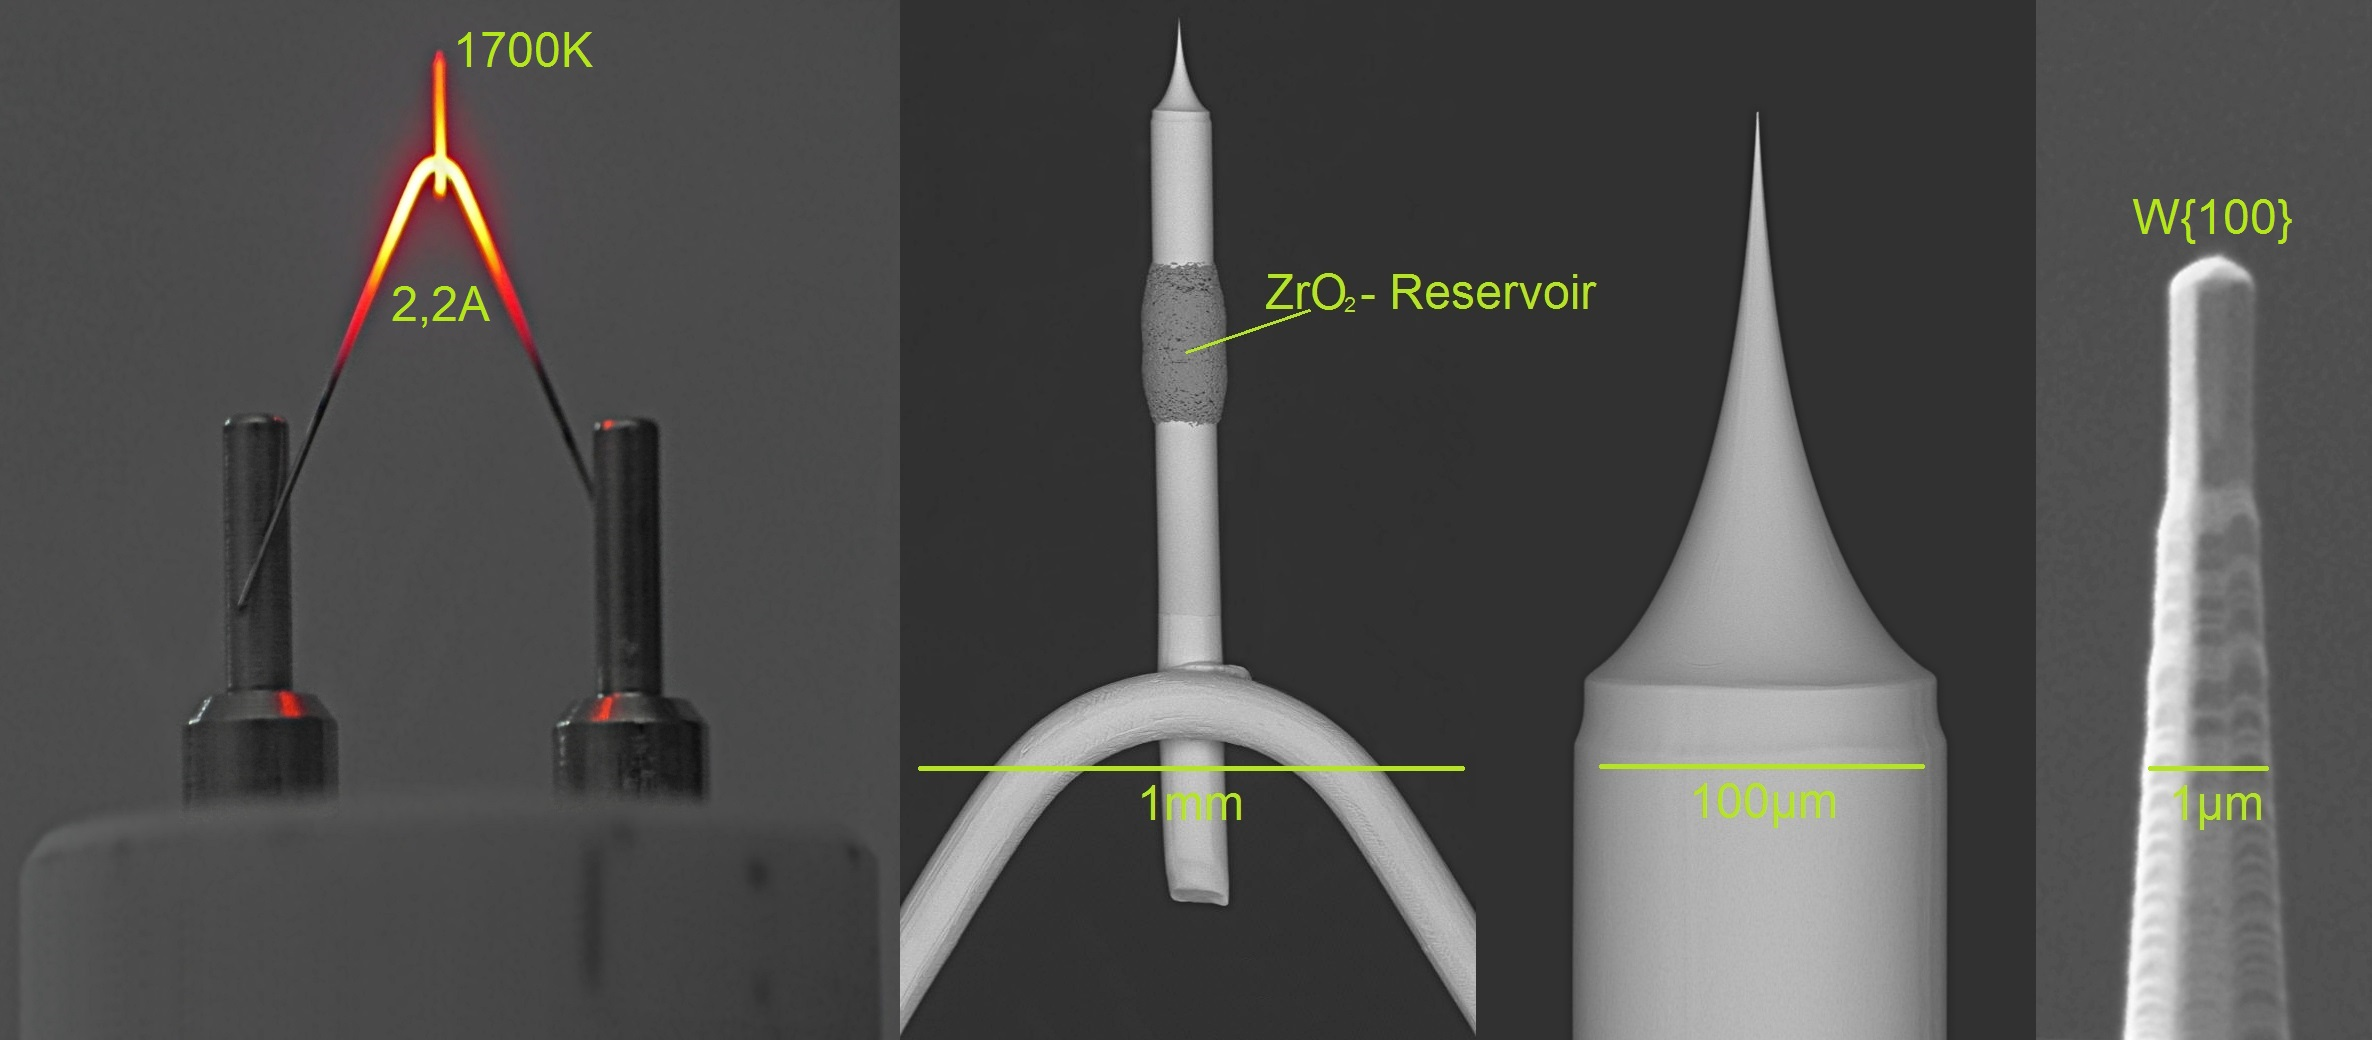
<br>
Figure 1 - Different views of a Schottky-Emitter. Source: Erwin Meier, 2020, [Thermionic emission](https://en.wikipedia.org/wiki/Thermionic_emission)

The electric field created by the potential difference between the anode and cathod works to accelerate the electrons at the surface of the cathode away from it, thus reducing the effective work function - which is the work required to remove the electons from their 'sea of electons' within the metal. <br>
The equation for the electron emis­sion is somewhat complex (see: Schottky effect, Fermi level), but the reduction in work required to eject an electron using an electric field is described by: <br>
\begin{equation}
\Delta W = \sqrt{\frac{q_e^3\overrightarrow{E}}{4\pi\epsilon_0}}
\end{equation}
Where E is the electric field at the tip of the cathode.

At local electric field intensities lower than approximately 10⁸ V/m, significant heating is required for electrons to overcome the work function of most metals, even with relativly sharp geometries. At higher field strength however, electrons can be ripped directly off of sufficiently sharp cathodes, even at room temperature. This is known as a cold field emmiter, and it is what I will be looking into in this worksheet (ask me about this choice later). 

Surprisingly (to me at least), finding the electric field of a finitely sharp needle is quite complex, and to achieve any reasonably simple formula necessitates a number of approximations and simplifications. Below is a figure of the analytic system which I will use to approximate the electric properties of the anode-cathode system: 

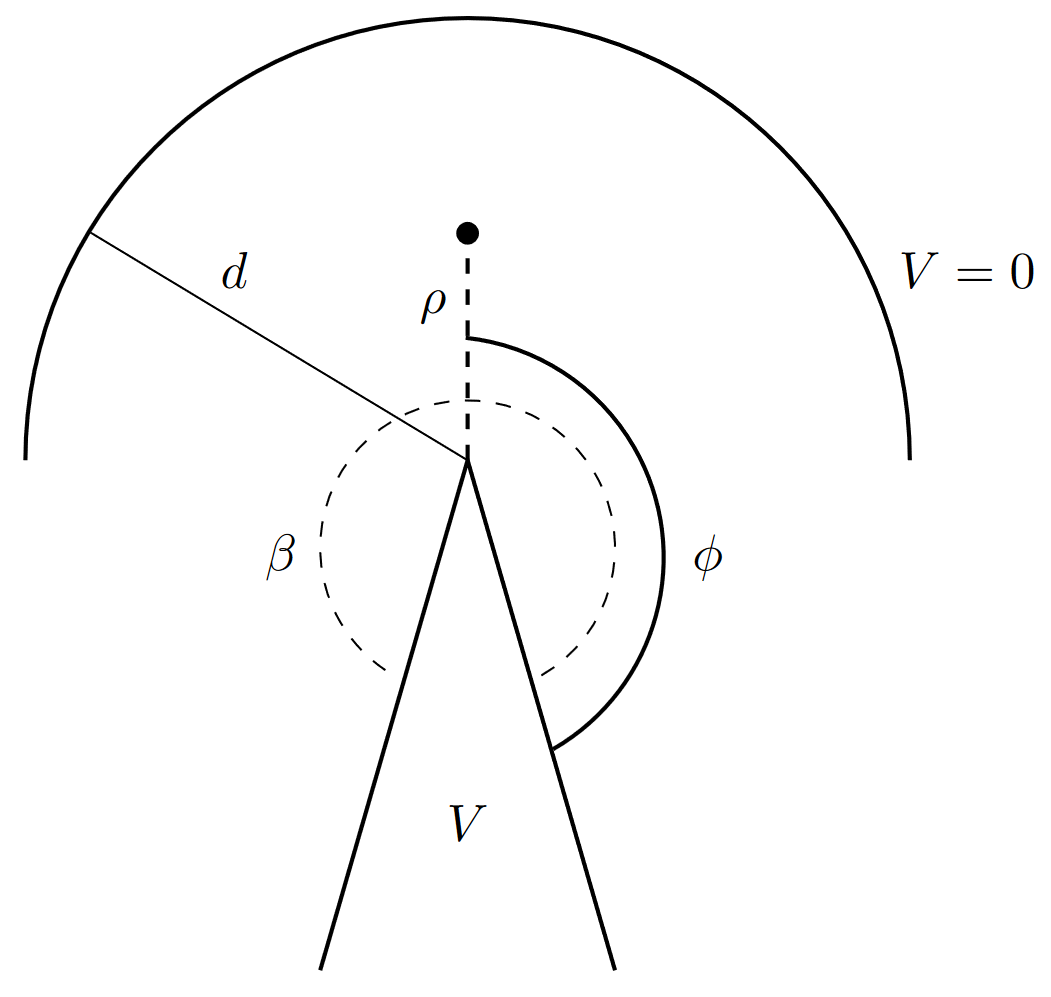
<br>
Figure 2 - Diagram of the analytic system

For the potential very near to the tip, which is the region of interest for our purposes, an approximation formula exists (Thank you Professor Johnston for finding this equation and walking me through solving it), and is as follows:

\begin{equation}
\Phi_{(\rho,\phi)} \approx V + a_1\rho^{\frac{\pi}{\beta}}\sin{\frac{\pi\phi}{\beta}}
\end{equation}

Where when we add a anode of reference potential (0) at a constant radius, we attain the constant:

\begin{equation}
a_1 = \frac{-4V}{\beta d^{\frac{\pi}{\beta}}}
\end{equation}

And by taking the negative partial derivatives in ρ and ϕ, we get the electric field. However, we are most interested in the total electric field, as there may be non-negligible fringing effects at the tip. To get this, we can take the egometric mean of the squares of the field components (in 2D at least):

\begin{equation}
\|E\|_{(\rho,\phi)} \approx \sqrt{(\frac{4V}{\beta d^{\frac{\pi}{\beta}}}\rho^{\frac{\pi}{\beta}-1}\sin{\frac{\pi\phi}{\beta}})^2+(\frac{4V}{\beta d^{\frac{\pi}{\beta}}}\rho^{\frac{\pi}{\beta}-1}\cos{\frac{\pi\phi}{\beta}})^2} = \frac{4V}{\beta d^{\frac{\pi}{\beta}}}\rho^{\frac{\pi}{\beta}-1}
\end{equation}

Which is not pretty to look at, however, observing closely it can be seen that most of the equation is consant, which makes it much easier to stomach. <br>
For the sake of reusing the variables from both the simulation and approximation, we will revisit this equation and its graph at the end of this worksheet. 

<br><br><br>
A model loosely based off of the 7th (laplace-equation) worksheet was created to simulate a wide variety of physical and electrical parameters pertaining to the finite needle, however, it's a mouthful, so let's just jump right in:

In [ ]:
##Import required libraries (code by Jesse Kinder and FEM on Colab project):

try:
    # Import gmsh library for generating meshes.
    import gmsh
except ImportError:
    # If it is not available, install it.  Then import it.
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

try:
    # Import FEniCSx libraries for finite element analysis.
    import dolfinx
except ImportError:
    # If they are not found, install them.  Then import them.
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

try:
    # Import multiphenicsx, mainly for plotting.
    import multiphenicsx
except ImportError:
    # If they are not found, install them.
    !pip3 install "multiphenicsx@git+https://github.com/multiphenics/multiphenicsx.git@8b97b4e"
    import multiphenicsx

# Import the rest of what we need.
import dolfinx.fem
import dolfinx.io
import gmsh
import mpi4py.MPI
import numpy as np
import petsc4py.PETSc
import ufl
import multiphenicsx.fem
import multiphenicsx.io

In [ ]:
##Code by Jordan Harris-Toovy, OIT Fall term, 2022

##Setup parametric variables and geometry:

#Radius of the semi-circular "tip" of the cathode
rad_circ = 0.5

#Distance from the base of the semicircle to the anode
dist_base = 50

#Distance from the center of the base of the semicircle to the side boundaries
dist_side = 10

#Distance from the base of the semicircle to lower boundary
dist_low = 12

#Angle between the vertical and walls of the main cathode
ang_wedge = (3.141592653589793/180) * 30

#Anode-cathode potential difference
pot_diff = 100

#Grid spacing
grid_space = 0.1

#Scaling factor (1 = 1m, 1000000 = 1um)
sys_scale = 1000000

#Number of dimensions
DIMS = 2

In [ ]:
##Scale variables
rad_circ /= sys_scale
dist_base /= sys_scale
dist_side /= sys_scale
dist_low /= sys_scale
grid_space /= sys_scale

In [ ]:
##Create gmsh system:

gmsh.initialize()
gmsh.model.add("mesh")

##Define geometry:

#Cathode tip semicircle points & curve (center of model)
pt_ori = gmsh.model.geo.addPoint(0, 0, 0, grid_space)
pt_arc0 = gmsh.model.geo.addPoint(-rad_circ, 0,0, grid_space)
pt_arc1 = gmsh.model.geo.addPoint(0, rad_circ, 0, grid_space)
pt_arc2 = gmsh.model.geo.addPoint(rad_circ, 0, 0, grid_space)

#Due to open arc not being able to have pi or greater angles in gmsh, the semicircle is made of two pi/2 arcs
cont_arc0 = gmsh.model.geo.addCircleArc(pt_arc0, pt_ori, pt_arc1)
cont_arc1 = gmsh.model.geo.addCircleArc(pt_arc1, pt_ori, pt_arc2)

#Top boundary (anode) points & line
pt_top0 = gmsh.model.geo.addPoint(-dist_side, dist_base, 0, grid_space)
pt_top1 = gmsh.model.geo.addPoint(dist_side, dist_base, 0, grid_space)
cont_top = gmsh.model.geo.addLine(pt_top0, pt_top1)

#Side boundarie's points & lines
pt_side0 = gmsh.model.geo.addPoint(-dist_side, -dist_low, 0, grid_space)
pt_side1 = gmsh.model.geo.addPoint(dist_side, -dist_low, 0, grid_space)
cont_side0 = gmsh.model.geo.addLine(pt_top0, pt_side0)
cont_side1 = gmsh.model.geo.addLine(pt_top1, pt_side1)

#Main cathode body points & lines
pt_bot0 = gmsh.model.geo.addPoint((-1.0 * dist_low * np.tan(ang_wedge)), -dist_low, 0, grid_space)
pt_bot1 = gmsh.model.geo.addPoint((dist_low * np.tan(ang_wedge)), -dist_low, 0, grid_space)
cont_cath0 = gmsh.model.geo.addLine(pt_arc0, pt_bot0)
cont_cath1 = gmsh.model.geo.addLine(pt_arc2, pt_bot1)
cont_cath2 = gmsh.model.geo.addLine(pt_bot0, pt_bot1)

#Remaining bottom segments
cont_bot0 = gmsh.model.geo.addLine(pt_side0, pt_bot0)
cont_bot1 = gmsh.model.geo.addLine(pt_side1, pt_bot1)

#Define the central cavity
cont_cav = gmsh.model.geo.addCurveLoops([cont_arc0, cont_arc1, cont_cath1, cont_bot1, cont_side1, cont_top, cont_side0, cont_bot0, cont_cath0])
surf_cav = gmsh.model.geo.addPlaneSurface(cont_cav)

#Apply new geometry
gmsh.model.geo.synchronize()

In [ ]:
##Setup groups and assign properties

#Cathode contours as physical groups 1-4
gmsh.model.addPhysicalGroup(1, [cont_cath0], 1)
gmsh.model.addPhysicalGroup(1, [cont_arc0], 2)
gmsh.model.addPhysicalGroup(1, [cont_arc1], 3)
gmsh.model.addPhysicalGroup(1, [cont_cath1], 4)

#Anode line as physical group 5
gmsh.model.addPhysicalGroup(1, [cont_top], 5)

#Sidewall contours as physical groups 6-9
gmsh.model.addPhysicalGroup(1, [cont_side0], 6)
gmsh.model.addPhysicalGroup(1, [cont_bot0], 7)
gmsh.model.addPhysicalGroup(1, [cont_side1], 8)
gmsh.model.addPhysicalGroup(1, [cont_bot1], 9)


#Setup domain in the central cavity surface as group 10
gmsh.model.addPhysicalGroup(DIMS, [surf_cav], 10)

##Create mesh
gmsh.model.mesh.generate(DIMS)

#Export mesh for external viewing (optional)
gmsh.write("system_mesh.msh")

##Create FEniCSx objects from gmsh model
FE_mesh, FE_subdoms, FE_bounds = dolfinx.io.gmshio.model_to_mesh(gmsh.model, comm=mpi4py.MPI.COMM_WORLD, rank=0, gdim=DIMS)

#Finalize and exit gmsh system
gmsh.finalize()

In [ ]:
##Rename FEniCSx object groups
FE_cathode1 = FE_bounds.indices[FE_bounds.values == 1]
FE_cathode2 = FE_bounds.indices[FE_bounds.values == 2]
FE_cathode3 = FE_bounds.indices[FE_bounds.values == 3]
FE_cathode4 = FE_bounds.indices[FE_bounds.values == 4]

FE_anode = FE_bounds.indices[FE_bounds.values == 5]

FE_swall1 = FE_bounds.indices[FE_bounds.values == 6]
FE_swall2 = FE_bounds.indices[FE_bounds.values == 7]
FE_swall3 = FE_bounds.indices[FE_bounds.values == 8]
FE_swall4 = FE_bounds.indices[FE_bounds.values == 9]

FE_cavity = FE_bounds.indices[FE_bounds.values == 10]

##Plot the resultant geometric objects

#Whole mesh (optional)
#multiphenicsx.io.plot_mesh(FE_mesh)

#Subdomains (optional)
#multiphenicsx.io.plot_mesh_tags(FE_subdoms)

#Boundaries
multiphenicsx.io.plot_mesh_tags(FE_bounds)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [ ]:
#Define trial & test functions
FE_TTSpace = dolfinx.fem.FunctionSpace(FE_mesh, ("Lagrange", 2))
FE_trial = ufl.TrialFunction(FE_TTSpace)
FE_test = ufl.TestFunction(FE_TTSpace)

#Create FEM function
FE_funct = dolfinx.fem.Function(FE_TTSpace)

#Designate the domain
FE_domain = FE_subdoms.indices[FE_subdoms.values == 1]

#Set up boundaries
FE_cathode_b1 = dolfinx.fem.locate_dofs_topological(FE_TTSpace, FE_bounds.dim, FE_cathode1)
FE_cathode_b2 = dolfinx.fem.locate_dofs_topological(FE_TTSpace, FE_bounds.dim, FE_cathode2)
FE_cathode_b3 = dolfinx.fem.locate_dofs_topological(FE_TTSpace, FE_bounds.dim, FE_cathode3)
FE_cathode_b4 = dolfinx.fem.locate_dofs_topological(FE_TTSpace, FE_bounds.dim, FE_cathode4)

FE_anode_b = dolfinx.fem.locate_dofs_topological(FE_TTSpace, FE_bounds.dim, FE_anode)

FE_swall_b1 = dolfinx.fem.locate_dofs_topological(FE_TTSpace, FE_bounds.dim, FE_swall1)
FE_swall_b2 = dolfinx.fem.locate_dofs_topological(FE_TTSpace, FE_bounds.dim, FE_swall2)
FE_swall_b3 = dolfinx.fem.locate_dofs_topological(FE_TTSpace, FE_bounds.dim, FE_swall3)
FE_swall_b4 = dolfinx.fem.locate_dofs_topological(FE_TTSpace, FE_bounds.dim, FE_swall4)

#Define potentials for essential boundary conditions
FE_anode_v = dolfinx.fem.Constant(FE_mesh, petsc4py.PETSc.ScalarType(0.0))
FE_e_bound = [dolfinx.fem.dirichletbc(FE_anode_v, FE_anode_b, FE_TTSpace)]

FE_cathode_v = dolfinx.fem.Constant(FE_mesh, petsc4py.PETSc.ScalarType(-1.0*pot_diff))
FE_e_bound += [dolfinx.fem.dirichletbc(FE_cathode_v, FE_cathode_b1, FE_TTSpace)]
FE_e_bound += [dolfinx.fem.dirichletbc(FE_cathode_v, FE_cathode_b2, FE_TTSpace)]
FE_e_bound += [dolfinx.fem.dirichletbc(FE_cathode_v, FE_cathode_b3, FE_TTSpace)]
FE_e_bound += [dolfinx.fem.dirichletbc(FE_cathode_v, FE_cathode_b4, FE_TTSpace)]

In [ ]:
#Laplace's equation (left side)
LE_left = ufl.inner(ufl.grad(FE_trial), ufl.grad(FE_test)) * ufl.dx

#Laplace's equation (right side)
LE_right = (dolfinx.fem.Constant(FE_mesh, petsc4py.PETSc.ScalarType(0.0))) * FE_test * ufl.dx

#Combine the parts of Laplace's equation into one object & solve
FEA_system = dolfinx.fem.petsc.LinearProblem(LE_left, LE_right, FE_e_bound, u=FE_funct)
FEA_system.solve()

#Misc fixes
FE_funct.vector.ghostUpdate(addv=petsc4py.PETSc.InsertMode.INSERT, mode=petsc4py.PETSc.ScatterMode.FORWARD)

In [ ]:
#Display the solution of Laplace's equation
multiphenicsx.io.plot_scalar_field(FE_funct, "Potential", warp_factor=(1/sys_scale))

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [ ]:
#Setup a vector-space and compute the gradient of the potential, combine via interpolation
FEA_vect_space = dolfinx.fem.VectorFunctionSpace(FE_mesh, ("Lagrange", 2))
FEA_e_field = dolfinx.fem.Function(FEA_vect_space)
FEA_ngrad_pot = dolfinx.fem.Expression(ufl.as_vector((-FE_funct.dx(0), -FE_funct.dx(1))), FEA_vect_space.element.interpolation_points())
FEA_e_field.interpolate(FEA_ngrad_pot)

#Plot the electric field
multiphenicsx.io.plot_vector_field(FEA_e_field,name="Electric Field", glyph_factor=1*10**(-sys_scale/10))

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

<br><br><br>
Now back to the analytical portion. <br>
Using the parameters from the simulation, we can plot the approximation function in the same scale and region.

In [ ]:
#Import matplotlib for convenience
import matplotlib.pyplot as plt

#Set up the grids (Only works when dist_side <= dist_low and dist_side <= dist_base)
x = np.linspace(-dist_side, dist_side, int(2*dist_side/grid_space))
y = np.linspace(-dist_side, dist_side, int(2*dist_side/grid_space))
X, Y = np.meshgrid(x, y)

#Define an approximate pi
api = 3.141592653589793

#Find the value of β
b = (2*ang_wedge - 2*api)

#Rename dist_base to d
d = dist_base

#Rename pot_diff to V
V = pot_diff

#Calculate the constant
C1, C2 = (4*V)/(b*(d**(api/b))), ((api/b)-1)

#calculate the function values over X and Y (using polar conversion)
Epr = -C1*np.power((np.sqrt(np.power(X,2)+np.power(Y,2))),C2)

#Plot the figure
fig = plt.figure()
plt.pcolormesh(x, y, Epr)
plt.colorbar()
plt.show()

So it can be seen that the electric field is is indeed concentrated at the tip, however the magnitude is significantly higher then the simulated results.<br>
Let's lead into the Q/A with my hypothesis for this discrepancy.